Lambda School Data Science, Unit 2: Predictive Modeling

# Kaggle Challenge, Module 1

## Assignment
- [X] Do train/validate/test split with the Tanzania Waterpumps data.
- [X] Define a function to wrangle train, validate, and test sets in the same way. Clean outliers and engineer features. (For example, [what other columns have zeros and shouldn't?](https://github.com/Quartz/bad-data-guide#zeros-replace-missing-values) What other columns are duplicates, or nearly duplicates? Can you extract the year from date_recorded? Can you engineer new features, such as the number of years from waterpump construction to waterpump inspection?)
- [X] Select features. Use a scikit-learn pipeline to encode categoricals, impute missing values, and fit a decision tree classifier.
- [X] Get your validation accuracy score.
- [X] Get and plot your feature importances.
- [X] Submit your predictions to our Kaggle competition. (Go to our Kaggle InClass competition webpage. Use the blue **Submit Predictions** button to upload your CSV file. Or you can use the Kaggle API to submit your predictions.)
- [X] Commit your notebook to your fork of the GitHub repo.


## Stretch Goals

### Reading

- A Visual Introduction to Machine Learning
  - [Part 1: A Decision Tree](http://www.r2d3.us/visual-intro-to-machine-learning-part-1/)
  - [Part 2: Bias and Variance](http://www.r2d3.us/visual-intro-to-machine-learning-part-2/)
- [Decision Trees: Advantages & Disadvantages](https://christophm.github.io/interpretable-ml-book/tree.html#advantages-2)
- [How a Russian mathematician constructed a decision tree — by hand — to solve a medical problem](http://fastml.com/how-a-russian-mathematician-constructed-a-decision-tree-by-hand-to-solve-a-medical-problem/)
- [How decision trees work](https://brohrer.github.io/how_decision_trees_work.html)
- [Let’s Write a Decision Tree Classifier from Scratch](https://www.youtube.com/watch?v=LDRbO9a6XPU) — _Don’t worry about understanding the code, just get introduced to the concepts. This 10 minute video has excellent diagrams and explanations._
- [Random Forests for Complete Beginners: The definitive guide to Random Forests and Decision Trees](https://victorzhou.com/blog/intro-to-random-forests/)


### Doing
- [ ] Add your own stretch goal(s) !
- [X] Try other [scikit-learn imputers](https://scikit-learn.org/stable/modules/impute.html).
- [ ] Try other [scikit-learn scalers](https://scikit-learn.org/stable/modules/preprocessing.html).
- [ ] Make exploratory visualizations and share on Slack.


#### Exploratory visualizations

Visualize the relationships between feature(s) and target. I recommend you do this with your training set, after splitting your data. 

For this problem, you may want to create a new column to represent the target as a number, 0 or 1. For example:

```python
train['functional'] = (train['status_group']=='functional').astype(int)
```



You can try [Seaborn "Categorical estimate" plots](https://seaborn.pydata.org/tutorial/categorical.html) for features with reasonably few unique values. (With too many unique values, the plot is unreadable.)

- Categorical features. (If there are too many unique values, you can replace less frequent values with "OTHER.")
- Numeric features. (If there are too many unique values, you can [bin with pandas cut / qcut functions](https://pandas.pydata.org/pandas-docs/stable/getting_started/basics.html?highlight=qcut#discretization-and-quantiling).)

You can try [Seaborn linear model plots](https://seaborn.pydata.org/tutorial/regression.html) with numeric features. For this problem, you may want to use the parameter `logistic=True`

You do _not_ need to use Seaborn, but it's nice because it includes confidence intervals to visualize uncertainty.

#### High-cardinality categoricals

This code from a previous assignment demonstrates how to replace less frequent values with 'OTHER'

```python
# Reduce cardinality for NEIGHBORHOOD feature ...

# Get a list of the top 10 neighborhoods
top10 = train['NEIGHBORHOOD'].value_counts()[:10].index

# At locations where the neighborhood is NOT in the top 10,
# replace the neighborhood with 'OTHER'
train.loc[~train['NEIGHBORHOOD'].isin(top10), 'NEIGHBORHOOD'] = 'OTHER'
test.loc[~test['NEIGHBORHOOD'].isin(top10), 'NEIGHBORHOOD'] = 'OTHER'
```



In [359]:
'''# If you're in Colab...
import os, sys
in_colab = 'google.colab' in sys.modules

if in_colab:
    # Install required python packages:
    # category_encoders, version >= 2.0
    # pandas-profiling, version >= 2.0
    # plotly, version >= 4.0
    !pip install --upgrade category_encoders pandas-profiling plotly
    
    # Pull files from Github repo
    os.chdir('/content')
    !git init .
    !git remote add origin https://github.com/LambdaSchool/DS-Unit-2-Kaggle-Challenge.git
    !git pull origin master
    
    # Change into directory for module
    os.chdir('module1')
    ''';

In [360]:
import pandas as pd
from sklearn.model_selection import train_test_split

train = pd.merge(pd.read_csv('../data/tanzania/train_features.csv'), 
                 pd.read_csv('../data/tanzania/train_labels.csv'))
test = pd.read_csv('../data/tanzania/test_features.csv')
sample_submission = pd.read_csv('../data/tanzania/sample_submission.csv')

print(train.shape, test.shape)

train, val = train_test_split(train, train_size=0.8, test_size=0.2,
                             stratify=train['status_group'],random_state=42)

print(train.shape, val.shape)

(59400, 41) (14358, 40)
(47520, 41) (11880, 41)


In [361]:
### Wrangle function
def wrangle(df):
    """I heard you like docstrings"""
    import numpy as np
    
    # Copy the dataframe to itself so warnings can shut up
    df = df.copy()
    # Thx for prelim work Ryan lol
    df['latitude'] = df['latitude'].replace(-2e-08,0)
    noZeroes = ['longitude','latitude','date_recorded','subvillage',
                'installer','region','basin']
    for col in noZeroes:
        df[col] = df[col].replace(0,np.nan)
        df[col] = df[col].replace('0',np.nan)
        
    # Drop dupes
    df = df.drop(columns=['quantity_group','scheme_management',
                          'extraction_type_group','payment_type'])
    
    # Make a date a date, and a year a year, god bless.
    df['date_recorded'] = pd.to_datetime(df['date_recorded'],infer_datetime_format=True)
    
    # YEEHAW dataframe return
    return df

### Select features, scikit-learn pipeline to encode categoricals, impute missing values, and fit a decision tree classifier.
import category_encoders as ce
from sklearn.impute import SimpleImputer
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

pipeline = make_pipeline(
    ## One hot encode
    ce.OneHotEncoder(use_cat_names=True),
    ## Imputer completes missing values
    #SimpleImputer(),
    IterativeImputer(),
    ## Scaler scales to unit variance, removing the mean(?)
    StandardScaler(),
    LogisticRegression(solver='lbfgs',multi_class='auto',max_iter=1000)
)

### Oh boy decision trees
from sklearn.tree import DecisionTreeClassifier

dt = make_pipeline(
    ## One hot encode
    ce.OneHotEncoder(use_cat_names=True),
    #SimpleImputer(),
    IterativeImputer(),
    DecisionTreeClassifier(min_samples_leaf=25,random_state=42)
)

### Reduce cardinality function for training and validation dataframesdef reduceCard(df1,df2,col,amt):
def reduceCard(df1,df2,col,amt):
    df1[col] = df1[col].astype(str)
    df2[col] = df2[col].astype(str)
    listoftop = df1[col].value_counts()[:amt].index
    df1.loc[~df1[col].isin(listoftop),col] = 'other'
    df2.loc[~df2[col].isin(listoftop),col] = 'other'
    return df1, df2

In [362]:
train = wrangle(train)
val = wrangle(val)
test = wrangle(test)

In [363]:
train.describe(exclude='number').T

,count,unique,top,freq,first,last
date_recorded,47520,349,2011-03-17 00:00:00,474,2002-10-14 00:00:00,2013-12-03 00:00:00
funder,44616,1716,Government Of Tanzania,7321,NaN,NaN
installer,43996,1928,DWE,13978,NaN,NaN
wpt_name,47520,30661,none,2879,NaN,NaN
basin,47520,9,Lake Victoria,8137,NaN,NaN
subvillage,47234,17231,Shuleni,420,NaN,NaN
region,47520,21,Iringa,4250,NaN,NaN
lga,47520,124,Njombe,2003,NaN,NaN
ward,47520,2082,Igosi,257,NaN,NaN
public_meeting,44876,2,True,40838,NaN,NaN


In [364]:
## Select features and target
target = 'status_group'
train_features = train.drop(columns=[target,'id','date_recorded'])

numeric_feat = train_features.select_dtypes(include='number').columns.tolist()
card = train_features.select_dtypes(exclude='number').nunique()
cat_feat = card[card<=50].index.tolist()
cat_feat += ['funder','ward','wpt_name','scheme_name',
            'subvillage','installer']
features = numeric_feat + cat_feat

X_train = train[features]
y_train = train[target]
X_val = val[features]
y_val = val[target]
X_test = test[features]

In [365]:
X_train, X_val = reduceCard(X_train,X_val,'funder',5)
X_train, X_val = reduceCard(X_train,X_val,'ward',5)
X_train, X_val = reduceCard(X_train,X_val,'wpt_name',5)
X_train, X_val = reduceCard(X_train,X_val,'scheme_name',10)
X_train, X_val = reduceCard(X_train,X_val,'subvillage',10)
X_train, X_val = reduceCard(X_train,X_val,'installer',5)
#X_train, X_val = reduceCard(X_train,X_val,'lga',0)
#pd.value_counts(X_train['wpt_name'].values,sort=True)

/home/ygeun/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:59: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/home/ygeun/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/home/ygeun/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/sta

In [366]:
''' Logistic Regression HIGHSCORE 77.0286
## Send it thru the pipes!
# Fit to train dataframes
pipeline.fit(X_train,y_train)
# Score on val dataframes
print(pipeline.score(X_val,y_val))
''';
#'''
## Send it thru a diff pipe!
dt.fit(X_train,y_train)
# score
#dt.score(X_train,y_train)
# score for val
dt.score(X_val,y_val)
#''';

0.7664983164983165

In [367]:
'''
# Put predict on this
y_pred = dt.predict(X_test)

# Write submission csv file
submission = sample_submission.copy()
submission['status_group'] = y_pred
submission.to_csv('../../sub-01.csv', index=False)
'''

"\n# Put predict on this\ny_pred = dt.predict(X_test)\n\n# Write submission csv file\nsubmission = sample_submission.copy()\nsubmission['status_group'] = y_pred\nsubmission.to_csv('../../sub-01.csv', index=False)\n"

In [368]:
import matplotlib.pyplot as plt

model = dt.named_steps['decisiontreeclassifier']

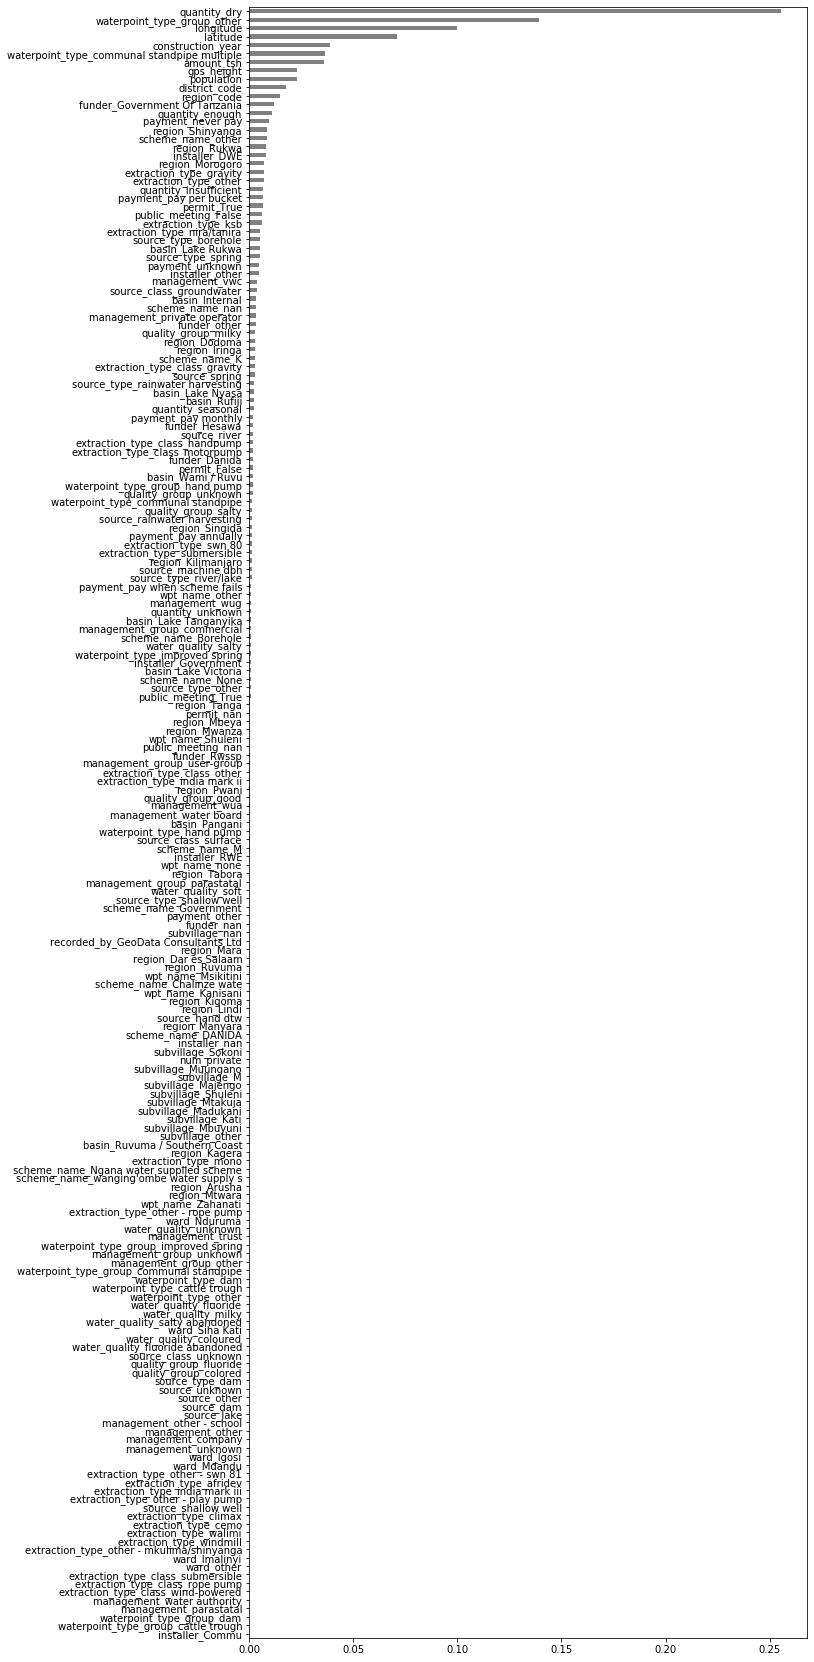

In [369]:
encoder = dt.named_steps['onehotencoder']
encoded_columns = encoder.fit_transform(X_train).columns
importances = pd.Series(model.feature_importances_, encoded_columns)
plt.figure(figsize=(10,30))
importances.sort_values().plot.barh(color='grey');